In [1]:
# We import some custom functions
from custom_functions import *

# We import the libraries
import pandas as pd
import pickle

In [2]:
df_original = pd.read_csv('sales_train.csv')

In [3]:
df_original.shape

(2935849, 6)

In [4]:
df_original.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

# Merges

To recover all the useful information, we merge the fact table **sales_train** with the other dimensions

In [5]:
# We read all the dataframes
df_sales = df_original.copy()

In [6]:
df_shops = pd.read_csv('shops.csv')
df_categories = pd.read_csv('item_categories.csv')
df_items = pd.read_csv('items.csv')

In [7]:
# We join the information between the categories and the items
df_categories_items = df_categories.merge(df_items, how='left', left_on='item_category_id', right_on='item_category_id')

In [8]:
# Firstly, we recover the information from the shops dimension, secondly from the categories and the items dimensions
df = df_sales.merge(df_shops, how='left', left_on='shop_id', right_on='shop_id')
df = df.merge(df_categories_items, how='left', left_on='item_id', right_on='item_id')

In [9]:
df.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154      999.00           1.0   
1  03.01.2013               0       25     2552      899.00           1.0   
2  05.01.2013               0       25     2552      899.00          -1.0   
3  06.01.2013               0       25     2554     1709.05           1.0   
4  15.01.2013               0       25     2555     1099.00           1.0   

                shop_name                   item_category_name  \
0  Ярославль ТЦ "Альтаир"                       Кино - Blu-Ray   
1     Москва ТРК "Атриум"                       Музыка - Винил   
2     Москва ТРК "Атриум"                       Музыка - Винил   
3     Москва ТРК "Атриум"                       Музыка - Винил   
4     Москва ТРК "Атриум"  Музыка - CD фирменного производства   

   item_category_id                                 item_name  
0                37                         ЯВЛЕНИЕ 2012 (BD)  
1                58  DEEP PURPLE  The House Of Blue Light  LP  
2                58  DEEP PURPLE  The House Of Blue Light  LP  
3                58  DEEP PURPLE  Who Do You Think We Are  LP  
4                56   DEEP PURPLE 30 Very Best Of 2CD (Фирм.)

In [24]:
df = df.drop_duplicates()

In [25]:
df.shape

(2935843, 10)

Now that we have all the potential useful features for the fact table, we can start to explore it. Of course, we already observe that many descriptions are in Cyrillic, which is confusing

# Exploratory Data Analysis I (EDA I)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935843 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                object 
 1   date_block_num      int64  
 2   shop_id             int64  
 3   item_id             int64  
 4   item_price          float64
 5   item_cnt_day        float64
 6   shop_name           object 
 7   item_category_name  object 
 8   item_category_id    int64  
 9   item_name           object 
dtypes: float64(2), int64(4), object(4)
memory usage: 246.4+ MB


In [34]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

date_block_num      shop_id      item_id   item_price item_cnt_day  \
count    2.93584e+06  2.93584e+06  2.93584e+06  2.93584e+06  2.93584e+06   
mean         14.5699      33.0017      10197.2      890.853      1.24264   
std          9.42299       16.227      6324.29       1729.8      2.61884   
min                0            0            0           -1          -22   
25%                7           22         4476          249            1   
50%               14           31         9343          399            1   
75%               23           47        15684          999            1   
max               33           59        22169       307980         2169   

      item_category_id  
count      2.93584e+06  
mean           40.0014  
std            17.1008  
min                  0  
25%                 28  
50%                 40  
75%                 55  
max                 83

We take a look at the date column according to the description of date_block_num that we found on the Kaggle webpage

In [28]:
df[df['date_block_num']==0]['date']

0         02.01.2013
1         03.01.2013
2         05.01.2013
3         06.01.2013
4         15.01.2013
             ...    
115685    19.01.2013
115686    18.01.2013
115687    26.01.2013
115688    31.01.2013
115689    07.01.2013
Name: date, Length: 115689, dtype: object

In [19]:
df[df['date_block_num']==33]['date']

2882335    23.10.2015
2882336    05.10.2015
2882337    02.10.2015
2882338    12.10.2015
2882339    04.10.2015
              ...    
2935844    10.10.2015
2935845    09.10.2015
2935846    14.10.2015
2935847    22.10.2015
2935848    03.10.2015
Name: date, Length: 53514, dtype: object

We also take a look at the item_price

In [37]:
len(df[df['item_price']==-1])

1

In [29]:
value_counts_csv(df)

In [30]:
count_nulls(df)

In [31]:
cols_names = [col for col in df.columns if col not in ['shop_name', 'item_name', 'item_category_name']]
hist_boxplot(df[cols_names])

## - First Remarks and ideas for each column: individual features

- First of all, there are **no null values** in this dataset

- **date**: 34 consecutive possible months for each item. The minimum (month, year) is Octuber 2013 and the maximum is Octuber 2015.
- **date_block_num**: minimum is 0 and maximum 33. By the definition of this column, this is strictly connected to the date column. We observe that for each value we can have a minimum of 50k items and a maximum of 143k
- **shop_id**: there are 60 different shops with sales data. We observe that the number of observations per shop goes from 0.3k to 235k. This suggests that some particular shops are able to manage many products (maybe they are bigger shops actually)
- **item_id**: we have 21807 different items. We observe that the item_id 20949 is more popular than the others by far. It is about the 1% of our observations
- **item_price**: for sure, looking at the boxplot, it is evident that there are some outliers. Indeed the mean which is 890 is very different from the median (390) and moreover the maximum value is bigger than 300k. There is also an observation with price equal to -1 
- **item_cnt_day**: almost the 90% of our observations has item_cnt_days equal to 1. Looking at the charts, we see that we have a lot of outliers and some negative values
- **item_category_id**: we have 84 distinct categories. Among them, there are three much more popular than the others. The category_id 40 has almost the 20% of the total observations. 
- **shop_name**: all the names are in Cyrillic. We could think of translating them to English to get some insights. We have the feeling that the name of the shop always contains the name of the city
- **item_name**: many names are in Cyrillic. Also in this case, we could think of translating them to English to get some insights

# Feature relations

# next time
- interpretazioni outliers e negativi
- vedere se item id del test sono gli stessi del training
- aggruppare per shop, mese e rifare una analisi: quanti prodotti vendono, a che prezzo medio etc, quante categorie etc.
- aggruppare per shop, mese e item e fare feature engineering vera per il modello

In [44]:
import matplotlib.pyplot as plt

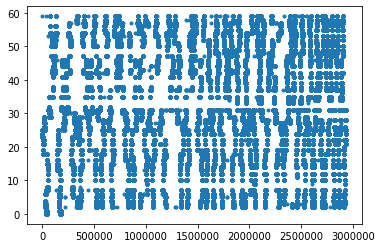

In [50]:
plt.plot(df['shop_id'], '.')

In [46]:
df.index

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            2935839, 2935840, 2935841, 2935842, 2935843, 2935844, 2935845,
            2935846, 2935847, 2935848],
           dtype='int64', length=2935843)

In [52]:
plt.scatter(range(len(df['shop_id'])), df['shop_id']), c=df['item_cnt_day']

SyntaxError: invalid syntax (<ipython-input-52-f698437947f5>, line 1)

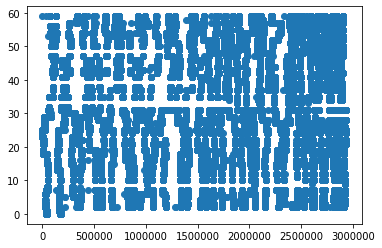

In [64]:
plt.scatter(range(len(df['shop_id'])), df['shop_id'])